# Check acceptance

In [3]:
import os.path as op
import pandas as pd
from definitions import dgen
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import particle


In [17]:
indir = "../../jobs/minbias-sim10Up08-xdigi/job-small"


In [18]:
loaded_algonames = [
    "hits_velo",
    "hits_ut",
    "hits_scifi",
    "mc_particles",
    # "event_info",
    # "mchits_velo"
]

dataframes = {}
for algoname in loaded_algonames:
    path = op.join(indir, algoname + ".csv")
    print("load", path)
    dataframes[algoname] = pd.read_csv(path, engine="pyarrow")
    # path = op.join(indir, algoname + ".parquet.lz4")
    # print("load", path)
    # dataframes[algoname] = pd.read_parquet(path, engine="pyarrow")

load ../../jobs/minbias-sim10Up08-xdigi/job-small/hits_velo.csv
load ../../jobs/minbias-sim10Up08-xdigi/job-small/hits_ut.csv
load ../../jobs/minbias-sim10Up08-xdigi/job-small/hits_scifi.csv
load ../../jobs/minbias-sim10Up08-xdigi/job-small/mc_particles.csv


In [19]:
print("="*80)
print(f"{'Det.':>12} {'# hits':>12} {'# fake hits':>12}  {'Proportion':>12} ")
for detector in dgen.all_detectors:
    dataframe = dataframes["hits_" + detector].reset_index(drop=True).drop_duplicates(["event", "lhcbid"])
    n = len(dataframe)
    nfake = sum(dataframe["mcid"] == -1)
    print(
        f"{detector:>12}"
        f"{n:>12,}"
        f"{nfake:>12,}"
        f"{nfake / n * 100 if n != 0 else -1:>12.1f}"
    )


        Det.       # hits  # fake hits    Proportion 
        velo     697,422     105,526        15.1
          ut     341,624      19,447         5.7
       scifi   1,406,495     453,995        32.3


In [17]:
dataframes["event_info"]

run  event  n_velo_hits  n_ut_hits  n_scifi_hits
0    6718861   6001         3769       2108          6488
1    6718861   6002          992        780          2226
2    6718861   6003         1595        835          2494
3    6718861   6004         1586        969          3112
4    6718861   6005         2361       1170          3731
..       ...    ...          ...        ...           ...
995  6718803    296          756        471          1239
996  6718803    297         1677       1108          3191
997  6718803    298          963        537          1405
998  6718803    299          337        308           961
999  6718803    300         2396       1439          4000

[1000 rows x 5 columns]

In [6]:
df_mc_particles = dataframes["mc_particles"]
# no_hits_index = (
#     (dataframes["mc_particles"]["nhits_velo"]
#     + dataframes["mc_particles"]["nhits_ut"]
#     + dataframes["mc_particles"]["nhits_scifi"]) < 3
# )
no_hits_index = (
    (dataframes["mc_particles"]["nhits_velo"]
    + dataframes["mc_particles"]["nhits_ut"]
    + dataframes["mc_particles"]["nhits_scifi"]) == 0
)


df_mc_particles_no_hits = df_mc_particles[no_hits_index]
df_mc_particles_with_hits = df_mc_particles[~no_hits_index]

In [7]:
nb_no_hits = len(df_mc_particles_no_hits)
nb_with_hits = len(df_mc_particles_with_hits)
prop_no_hits = nb_no_hits / (nb_no_hits + nb_with_hits)
print("Proportion of MC particles without hits:", prop_no_hits*100, '%')

Proportion of MC particles without hits: 83.32517767680298 %


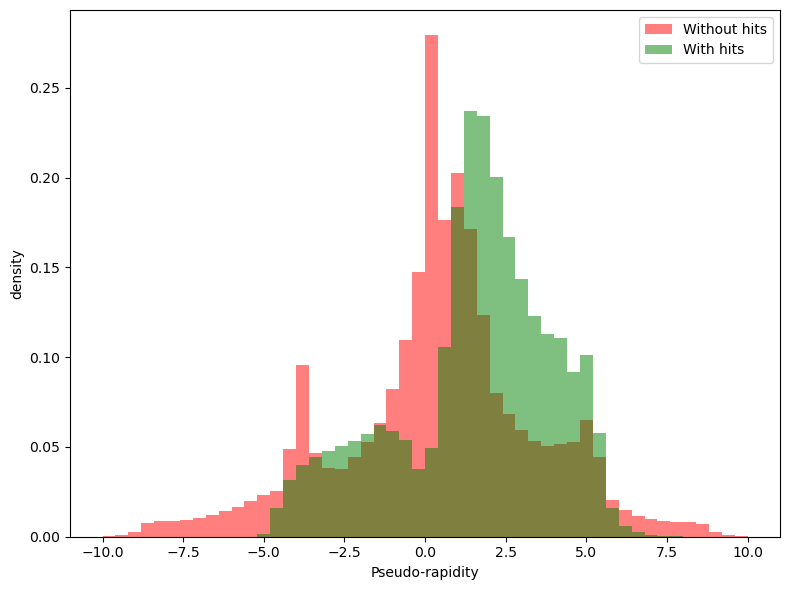

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(
    df_mc_particles_no_hits["eta"],
    range=(-10, 10),
    color='r',
    density=True,
    alpha=0.5,
    label="Without hits",
    bins=50
)
ax.hist(
    df_mc_particles_with_hits["eta"],
    range=(-10, 10),
    color='g',
    density=True,
    alpha=0.5,
    label="With hits",
    bins=50
)

ax.set_xlabel("Pseudo-rapidity")
ax.set_ylabel("density")
ax.legend()
fig.tight_layout()
fig.savefig("dist_pseudo_rapidity_mc_particles")

In [10]:
nb = 20


34

In [12]:
def get_table_prop(dataframe):
    unique_pids = np.abs(dataframe["pid"])
    pids, counts = np.unique(unique_pids, return_counts=True)
    sort_indices = np.argsort(counts)[::-1]
    pids = pids[sort_indices]
    props = counts[sort_indices] / counts.sum()


    print('|', f"{'Particle':>11}", '|', f"{'PID':>11}", '|', f"{'Proportion':>11}", '|')
    print('|', "-"*11, '|', "-"*11, '|', "-"*11, '|')
    for pid, prop in zip(pids[:nb], props[:nb]):
        try:
            particle_name = particle.Particle.from_pdgid(pid).name
        except particle.InvalidParticle:
            particle_name = "?"
        print('|', f"{particle_name:>11}", '|', f"{pid:>11}", '|' f"{prop*100:>11.2f}%", '|')

    if nb < len(pids):
        print('|', f"{'...':>11}", '|', f"{'...':>11}", '|', f"{'...':>11}", '|')

    print("Number of particle species:", len(pids))

In [13]:
get_table_prop(
    df_mc_particles_no_hits.query("2 < eta < 5")
)

|    Particle |         PID |  Proportion |
| ----------- | ----------- | ----------- |
|       gamma |          22 |      44.98% |
|          e- |          11 |      16.71% |
|         pi0 |         111 |      12.24% |
|         pi+ |         211 |       5.84% |
|           n |        2112 |       3.71% |
|         eta |         221 |       1.54% |
|   rho(770)+ |         213 |       1.43% |
|           p |        2212 |       1.42% |
|          K0 |         311 |       1.25% |
|       K(L)0 |         130 |       1.19% |
|       K(S)0 |         310 |       1.17% |
|  omega(782) |         223 |       0.91% |
|   rho(770)0 |         113 |       0.87% |
|      nu(mu) |          14 |       0.82% |
|      Lambda |        3122 |       0.61% |
|          K+ |         321 |       0.57% |
|   eta'(958) |         331 |       0.56% |
|    K*(892)0 |         313 |       0.52% |
|    K*(892)+ |         323 |       0.51% |
|         mu- |          13 |       0.41% |
|         ... |         ... |   

In [14]:
get_table_prop(
    df_mc_particles_with_hits.query("2 < eta < 5")
)

|    Particle |         PID |  Proportion |
| ----------- | ----------- | ----------- |
|          e- |          11 |      52.85% |
|         pi+ |         211 |      36.08% |
|           p |        2212 |       5.12% |
|          K+ |         321 |       4.21% |
|         mu- |          13 |       1.32% |
|      Sigma- |        3112 |       0.13% |
|      Sigma+ |        3222 |       0.11% |
|          D2 |  1000010020 |       0.06% |
|         Xi- |        3312 |       0.04% |
|         He4 |  1000020040 |       0.03% |
|          T3 |  1000010030 |       0.01% |
|          H4 |  1000010040 |       0.01% |
|         He3 |  1000020030 |       0.01% |
|      Omega- |        3334 |       0.00% |
|         Li4 |  1000030040 |       0.00% |
|        Al26 |  1000130260 |       0.00% |
|         B10 |  1000050100 |       0.00% |
|         Be9 |  1000040090 |       0.00% |
|        Al27 |  1000130270 |       0.00% |
|         Li7 |  1000030070 |       0.00% |
|         ... |         ... |   